# Day2
- batch normalization
- drop out
- regularization
- early stopping

In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader


In [2]:
## 다음과 같이 받을 수도 있지만 그냥 sklearn을 통해 가져오겠음
# from torchvision import datasets
# from torchvision import transforms
# mnist_train = datasets.MNIST(root='MNIST_data/',
#                           train=True,
#                           transform=transforms.ToTensor(),
#                           download=True)
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',as_frame=False, cache=False)


Bad key "text.kerning_factor" on line 4 in
/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


Text(0.5, 1.0, 'label: 5')

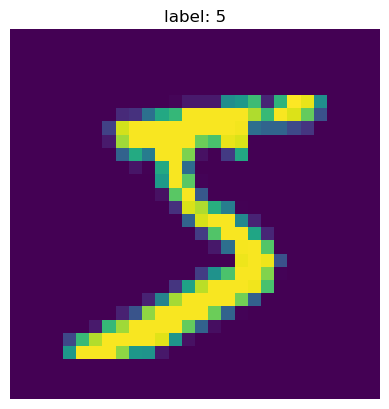

In [3]:
from matplotlib import pyplot as plt

i=0
plt.imshow(mnist.data[i,:].reshape(28,28))
plt.axis('off')
plt.title('label: {}'.format(mnist.target[i]))

In [4]:
X = mnist.data.astype('float32')
y = mnist.target.astype('int64')
X /= 255.0

In [5]:
# torch에서의 regularization은 생략
# optimizer에 weight decay를 넣어서 비슷한 효과를 낼 수는 있는데 layer마다 다르게 하는 방법은 모르겠습니다.

# Dropout, BatchNormalization, LazyNormalization
class BatchNorm_net(nn.Module):
    def __init__(self, input_shape, output_shape):
        super().__init__()
        self.fc1 = nn.Linear(input_shape, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, output_shape)

        self.relu = nn.ReLU()
        self.dropout_1 = nn.Dropout(0.5)
        self.dropout_2 = nn.Dropout(0.3)
        self.batchnorm_1 = nn.BatchNorm1d(512)
        self.batchnorm_2 = nn.LazyBatchNorm1d(64)
    def forward(self,x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout_1(x)
        x = self.batchnorm_1(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.dropout_2(x)
        x = self.batchnorm_2(x)
        x = self.fc3(x)
        return x


In [6]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42,
                                                    test_size=10000)

In [7]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, random_state=42, 
                                                    test_size=10000)

In [8]:
X_train.shape, X_val.shape, X_test.shape, y_test.shape

((50000, 784), (10000, 784), (10000, 784), (10000,))

In [40]:
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split
from skorch.dataset import Dataset
from skorch.callbacks import Checkpoint, EarlyStopping

train_ds = Dataset(X_train, y_train)
valid_ds = Dataset(X_val, y_val)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# early stopping 및 best model check point 저장
# 순수 torch에서는 직접 짜야함
checkpoint = Checkpoint(monitor='valid_loss_best', load_best=True)
earlystopping = EarlyStopping(patience=5, monitor='valid_loss')

net = NeuralNetClassifier(
    BatchNorm_net(784,10),
    max_epochs=25,
    lr=0.001,
    optimizer=torch.optim.RMSprop,
    batch_size=64,
    criterion=nn.CrossEntropyLoss,
    device=device,
    train_split=predefined_split(valid_ds),
    callbacks=[checkpoint,earlystopping]
)

/home/choiyj/.conda/envs/choi/lib/python3.8/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


In [41]:
net.fit(train_ds, y=None)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        0.3536       0.9592        0.1356     +  3.0266
      2        0.1978       0.9692        0.1046     +  3.0336
      3        0.1683       0.9719        0.0927     +  3.0014
      4        0.1511       0.9744        0.0862     +  2.9514
      5        0.1390       0.9754        0.0824     +  2.9527
      6        0.1258       0.9763        0.0789     +  3.0150
      7        0.1188       0.9764        0.0785     +  2.9997
      8        0.1156       0.9776        0.0747     +  2.9975
      9        0.1085       0.9770        0.0773        3.0540
     10        0.1018       0.9785        0.0736     +  2.9943
     11        0.1024       0.9786        0.0720     +  3.0225
     12        0.0985       0.9783        0.0714     +  2.9971
     13        0.0926       0.9800        0.0684     +  2.9486
     14        0.0907       0.9800        0.0689       

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=BatchNorm_net(
    (fc1): Linear(in_features=784, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=64, bias=True)
    (fc3): Linear(in_features=64, out_features=10, bias=True)
    (relu): ReLU()
    (dropout_1): Dropout(p=0.5, inplace=False)
    (dropout_2): Dropout(p=0.3, inplace=False)
    (batchnorm_1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (batchnorm_2): BatchNorm1d(64, eps=64, momentum=0.1, affine=True, track_running_stats=True)
  ),
)

In [43]:
from sklearn.metrics import accuracy_score as acc
y_pred = net.predict(X_val)
# 실제로 best valid_loss에서의 acc값이 반환된 것 확인
acc(y_val, y_pred)

0.9803

In [44]:
from sklearn.metrics import accuracy_score as acc
y_pred = net.predict(X_test)
acc(y_test, y_pred)

0.9763

# CNN

In [49]:
!pwd

/home/choiyj/tf2torch


In [56]:
# torch로 받으려면 download 파일이 생기므로 데이터만 keras로 받아오기로함
import torchvision

transform = torchvision.transforms.Compose(
    [torchvision.transforms.ToTensor(),
     torchvision.transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./../data', train=True,
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root='./../data', train=False,
                                        download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [57]:
from torch.utils.data import random_split
trainset, valset = random_split(trainset, [0.8,0.2])

In [58]:
len(trainset), len(valset), len(testset)

(40000, 10000, 10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


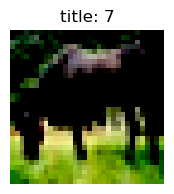

In [77]:
i = 2
temp_img, temp_target = trainset[i]
plt.figure(figsize=(2,2))
plt.imshow(temp_img.permute(1,2,0))
plt.axis('off')
plt.title(f'title: {temp_target}')
plt.show()

In [120]:
class SimpleCNN(nn.Module):
    def __init__(self,output_shape):
        super().__init__()
        self.conv = nn.Conv2d(3, 32, kernel_size=3, stride=1)
        self.maxpool = nn.MaxPool2d(2)
        self.fc1 = nn.Linear(32*15*15, 512)
        self.fc2 = nn.Linear(512, output_shape)
        self.relu = nn.ReLU()
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        
    def forward(self,x):
        x = self.conv(x)
        x = self.relu(x)
        x = self.maxpool(x)
        x = self.dropout1(x)
        # batch를 제외한 flatten
        x = torch.flatten(x,1)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        return x


In [121]:

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

checkpoint = Checkpoint(monitor='valid_loss_best', load_best=True)
earlystopping = EarlyStopping(patience=5, monitor='valid_loss')
net = NeuralNetClassifier(
    SimpleCNN(10),
    max_epochs=25,
    lr=0.001,
    optimizer=torch.optim.RMSprop,
    batch_size=128,
    criterion=nn.CrossEntropyLoss,
    device=device,
    train_split=predefined_split(valset),
    callbacks=[checkpoint,earlystopping]
)

In [119]:
model = SimpleCNN(10)
a,b = trainset[70]
model(a.unsqueeze(0))

tensor([-0.0565,  0.0731,  0.1779, -0.1929, -0.0325,  0.0333, -0.0717,  0.1028,
        -0.1308, -0.0810], grad_fn=<AddBackward0>)

In [126]:
net.fit(trainset, y=None)

  epoch    train_loss    valid_acc    valid_loss    cp     dur
-------  ------------  -----------  ------------  ----  ------
      1        1.7951       0.5146        1.3600     +  8.4071
      2        1.3724       0.5605        1.2290     +  8.1689
      3        1.2582       0.5492        1.2395        8.1484
      4        1.1734       0.6050        1.0969     +  8.1409
      5        1.1057       0.6138        1.0801     +  8.1568
      6        1.0489       0.6311        1.0303     +  8.1411
      7        1.0024       0.6392        1.0196     +  8.1118
      8        0.9640       0.6410        1.0155     +  8.1129
      9        0.9245       0.6358        1.0390        8.1040
     10        0.8887       0.6556        0.9928     +  8.1026
     11        0.8592       0.6466        1.0295        8.1184
     12        0.8258       0.6562        0.9866     +  8.0933
     13        0.7967       0.6649        0.9764     +  8.2030
     14        0.7719       0.6658        0.9749     + 

<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=SimpleCNN(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (maxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (fc1): Linear(in_features=7200, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=10, bias=True)
    (relu): ReLU()
    (dropout1): Dropout(p=0.25, inplace=False)
    (dropout2): Dropout(p=0.5, inplace=False)
  ),
)

In [139]:
y_pred = net.predict(testset)
acc(testset.targets, y_pred)

0.6659